In [6]:
from TSInterpret.data import load_data
import sklearn
import pickle
import numpy as np 
import torch 
from ClassificationModels.CNN_T import ResNetBaseline, get_all_preds, fit, UCRDataset
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import pandas as pd
import os 

# Parameters

In [7]:
dataset='ElectricDevices'

# Load Data

In [8]:
#TODO include OneHot Encoding Options
train_x,test_x, train_y, test_y = load_data.load_basic_dataset(dataset,scaling=None,mode='feat',cwd='/media/jacqueline/Data/UCRArchive_2018/')

In [9]:
print(test_y.shape)

(7711,)


In [10]:
enc1=sklearn.preprocessing.OneHotEncoder(sparse=False).fit(np.vstack((train_y.reshape(-1,1),test_y.reshape(-1,1))))
pickle.dump(enc1,open(f'../ClassificationModels/models/{dataset}/OneHotEncoder.pkl','wb'))

train_y=enc1.transform(train_y.reshape(-1,1))
test_y=enc1.transform(test_y.reshape(-1,1))
    

# Model Training

In [11]:
n_pred_classes =train_y.shape[1]
train_dataset = UCRDataset(train_x.astype(np.float64),train_y.astype(np.int64))
test_dataset = UCRDataset(test_x.astype(np.float64),test_y.astype(np.int64))
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=16,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=1,shuffle=False)
model = ResNetBaseline(in_channels=1, num_pred_classes=n_pred_classes)
fit(model,train_loader,test_loader)
if dataset in os.listdir('../ClassificationModels/models/'):
    print('Folder exists')
else: 
    os.mkdir(f'../ClassificationModels/models/{dataset}')
torch.save(model.state_dict(), f'../ClassificationModels/models/{dataset}/ResNet')

test_preds, ground_truth = get_all_preds(model, test_loader)
ground_truth=np.argmax(ground_truth,axis=1)

sns.set(rc={'figure.figsize':(5,4)})
heatmap=confusion_matrix(ground_truth, test_preds)
sns.heatmap(heatmap, annot=True)
plt.savefig(f'../ClassificationModels/models/{dataset}/ResNet_confusion_matrix.png')
plt.close()
acc= accuracy_score(ground_truth, test_preds)
a = classification_report(ground_truth, test_preds, output_dict=True)
dataframe = pd.DataFrame.from_dict(a)
dataframe.to_csv(f'../ClassificationModels/models/{dataset}/classification_report.csv', index = False)

Epoch: 1, Train loss: 0.855, Val loss: 1.553
Epoch: 2, Train loss: 0.716, Val loss: 2.019
Epoch: 3, Train loss: 0.516, Val loss: 1.965
Epoch: 4, Train loss: 0.467, Val loss: 1.944
Epoch: 5, Train loss: 0.431, Val loss: 2.023
Epoch: 6, Train loss: 0.41, Val loss: 2.031
Epoch: 7, Train loss: 0.383, Val loss: 2.579
Epoch: 8, Train loss: 0.36, Val loss: 2.728
Epoch: 9, Train loss: 0.338, Val loss: 1.735
Epoch: 10, Train loss: 0.333, Val loss: 1.988
Epoch: 11, Train loss: 0.306, Val loss: 2.704
Epoch: 12, Train loss: 0.29, Val loss: 2.79
Epoch: 13, Train loss: 0.28, Val loss: 2.142
Epoch: 14, Train loss: 0.268, Val loss: 2.348
Epoch: 15, Train loss: 0.263, Val loss: 2.389
Epoch: 16, Train loss: 0.244, Val loss: 2.343
Epoch: 17, Train loss: 0.248, Val loss: 2.285
Epoch: 18, Train loss: 0.233, Val loss: 1.684
Epoch: 19, Train loss: 0.237, Val loss: 2.372
Epoch: 20, Train loss: 0.212, Val loss: 2.193
Epoch: 21, Train loss: 0.21, Val loss: 2.285
Epoch: 22, Train loss: 0.2, Val loss: 1.737
Epoch

# Explanation Algo

In [ ]:
item=test_x[10].reshape(1,1,-1)
shape=item.shape
_item=  torch.from_numpy(item).float()
model.eval()
#y_target= model(_item).detach().numpy()
y_target = torch.nn.functional.softmax(model(_item)).detach().numpy()

/home/jacqueline/.local/share/virtualenvs/InterpretabiltyTimeSeries-y2AnfPaS/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


In [ ]:
print(y_target)

[[4.3103665e-08 4.4459858e-09 1.8939334e-20 1.4708588e-02 3.6387026e-01
  6.2138438e-01 3.6688572e-05]]


In [ ]:
from TSInterpret.InterpretabilityModels.counterfactual.NativeGuideCF import NativeGuideCF
exp_model=NativeGuideCF(model,shape,(train_x,train_y), backend='PYT', mode='feat')

2022-06-09 13:19:11.578117: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/jacqueline/.local/share/virtualenvs/InterpretabiltyTimeSeries-y2AnfPaS/lib/python3.7/site-packages/cv2/../../lib64:
2022-06-09 13:19:11.578138: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [ ]:
exp,label=exp_model.explain(item, np.argmax(y_target,axis=1),method='native_guide')

[5]
Native Guide [[8.0028340e-02 1.7512009e-04 5.1854914e-01 1.4531234e-01 1.6123196e-01
  5.5793131e-04 9.4145082e-02]]
Starting Points 95
Subarray Length 1
Prob_target [0.57632726]
starting 94
2
False
Prob_target [0.47637454]


In [ ]:
label=0

In [ ]:
print(exp)

[[-0.24948841 -0.24948841 -0.24948841 -0.24948841 -0.24948841 -0.24948841
  -0.24948841 -0.24948841 -0.24948841 -0.24948841 -0.24948841  0.66096839
   5.8153287   1.2483599   0.36727264  0.36727264  0.13231605  0.23510956
   0.23510956  0.22042477  0.26447913 -0.24948841 -0.24948841 -0.24948841
  -0.24948841 -0.24948841 -0.24948841 -0.24948841 -0.24948841 -0.24948841
  -0.24948841 -0.24948841 -0.24948841 -0.24948841 -0.24948841 -0.24948841
  -0.24948841 -0.24948841 -0.24948841 -0.24948841 -0.24948841 -0.24948841
  -0.24948841 -0.24948841 -0.24948841 -0.24948841 -0.24948841 -0.24948841
  -0.24948841 -0.24948841 -0.24948841 -0.13201012  5.4628938   4.8755023
  -0.05858618  0.02952254  0.23510956 -0.24948841 -0.24948841 -0.24948841
  -0.24948841 -0.24948841 -0.24948841 -0.24948841 -0.24948841 -0.24948841
  -0.24948841 -0.24948841 -0.24948841 -0.24948841 -0.24948841 -0.24948841
  -0.24948841 -0.24948841 -0.24948841 -0.24948841 -0.24948841 -0.24948841
  -0.24948841 -0.24948841 -0.24948841 -

In [ ]:
print(exp.shape)

(1, 96)


# Plot Item 

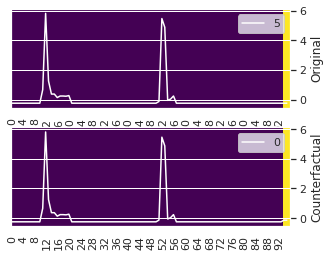

In [ ]:

exp_model.plot(item,np.argmax(y_target,axis=1)[0],exp,label)

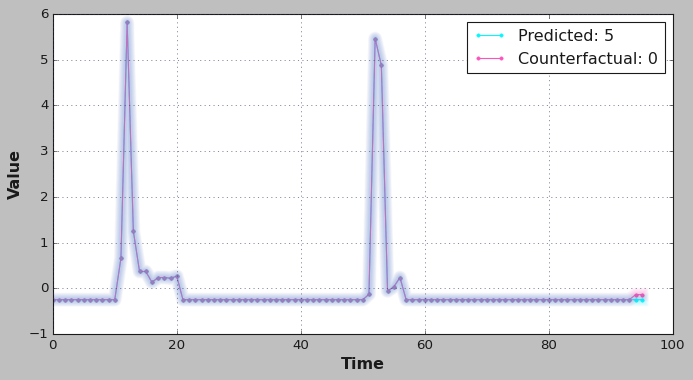

In [ ]:
exp_model.plot_in_one(item,np.argmax(y_target,axis=1)[0],exp,label)